<a href="https://colab.research.google.com/github/lluisdn/TFM/blob/Calibration/TransferLearning_lastlayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer-Learning


*   Load a pretrained ResNet50 model without last FC layer (include_top=False) for Imagenet.
*   Fine-tune last few layers by adding GAP and SoftMax.

*   Resize input images for CIFAR100 to larger ones as ResNet50 is trained with 224x224.
*   Make BatchNormalization layers as trainable, this is needed because when using Frozen model,if the batch statistics (mean/variance) of frozen layers are used and if the target dataset is different from one which was used for training, this will result in degrading of accuracy (https://github.com/keras-team/keras/pull/9965)


*   Add Cut-Out as an augmentation strategy.
*   Trained for 15 epochs with BatchSize of 64 and reached 80.16% val-accuracy.










#**Imports**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
#from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

#**Preprocess**

In [ ]:
import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [ ]:
num_classes = 100
nb_epochs = 10

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

#Pre-process the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
datagen.fit(x_train)
datagen.fit(x_test)

y_train_hot_encoded = np_utils.to_categorical(y_train, num_classes)
y_test_hot_encoded = np_utils.to_categorical(y_test, num_classes)

#**Plot**

[0]


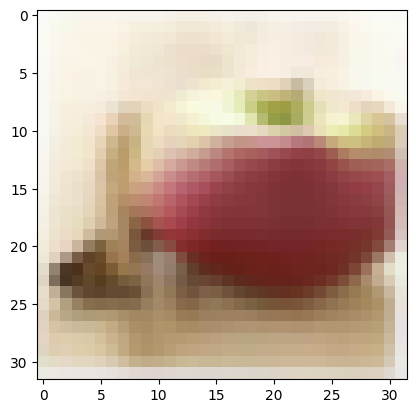

In [ ]:
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
# Plot the first image in x_train
plt.imshow(x_train[2])
print(y_train[2])

# Display the plot
plt.show()

#**Fine-tuning ResNet model**

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
t=time.time()
historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=64),
                                  steps_per_epoch=x_train.shape[0] // 64,
                                  epochs=12,
                                  #validation_data=(x_test, y_test)
                                  )
print('Training time: %s' % (t - time.time()))

<ipython-input-80-81a3ca63f63e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historytemp = model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/12
781/781 [==============================] - 484s 594ms/step - loss: 30608.2363 - accuracy: 0.0091
Epoch 2/12
 42/781 [>.............................] - ETA: 7:20 - loss: 39537.0703 - accuracy: 0.0056

KeyboardInterrupt: ignored

In [ ]:
model.summary()

ValueError: ignored

#**Load model (new_model)**

In [ ]:
new_model = tf.keras.models.load_model('my_model.h5')

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_3 (UpSampling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 up_sampling2d_4 (UpSampling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 up_sampling2d_5 (UpSampling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                             

#**Logit model**

In [ ]:
new_model.layers[-1].activation = tf.keras.activations.linear
new_model.save('model_logits.h5')
logit_model = tf.keras.models.load_model('model_logits.h5')

In [ ]:
logit_model.layers[-1].activation

<function keras.activations.linear(x)>

In [ ]:
logits=logit_model.predict(x_test)

313/313 [==============================] - 1921s 6s/step


In [ ]:
import pandas as pd
import numpy as np

# create a list of columns for the DataFrame
columns = []
for i in range(100):
    columns.append(f'logits_{i}')
    columns.append(f'label_{i}')

# create a list of arrays for the DataFrame
data = []
for i in range(100):
    data.append(logits[:, i])
    data.append(y_test_hot_encoded[:, i])

# create the DataFrame
df = pd.DataFrame(np.array(data).T, columns=columns)
df.to_csv('output_logits.csv', index=False)

In [ ]:
print(len(logits[0]))
print(logits[0])

In [ ]:
import scipy
probs_array=[]

for logit in logits:
  probs = scipy.special.softmax(logit)
  probs_array.append(probs)


#scaled_probs = scipy.special.softmax(logits)
#print(probs)

In [ ]:
print(np.argmax(logits[0]))

#**Class temperature layer**

In [ ]:
class Temperature(tf.keras.layers.Layer):
  def __init__(self, name=None **kwargs):
    super(Temperature, self).__init__()

  def build(self, input_shape):
    self.T = self.add_weight("T", shape=[1])

  def call(self, inputs):
    return tf.keras.activations.softmax(inputs/tf.keras.activations.softplus(self.T))

#**Model temperature fine tuning**

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model_temperature = Sequential()
model_temperature.add(UpSampling2D())
model_temperature.add(UpSampling2D())
model_temperature.add(UpSampling2D())
model_temperature.add(resnet_model)
model_temperature.add(GlobalAveragePooling2D())
model_temperature.add(Dense(256, activation='relu'))
model_temperature.add(Dropout(.25))
model_temperature.add(BatchNormalization())
model_temperature.add(Dense(num_classes, activation='linear'))
model_temperature.add(Temperature())

model_temperature.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
num_classes = 100
nb_epochs = 10

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

#Pre-process the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
datagen.fit(x_train)
datagen.fit(x_test)

#y_train = np_utils.to_categorical(y_train, num_classes)
#y_test = np_utils.to_categorical(y_test, num_classes)

#*Model_temperature weights initialization*


In [ ]:
t=time.time()
historytemp = model_temperature.fit_generator(datagen.flow(x_train, y_train_hot_encoded,
                                  batch_size=64),
                                  steps_per_epoch=x_train.shape[0] // 64,
                                  epochs=1,
                                  validation_data=(x_test, y_test))
print('Training time: %s' % (t - time.time()))

<ipython-input-18-1b5081eeb1af>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historytemp = model_temperature.fit_generator(datagen.flow(x_train, y_train_hot_encoded,


 43/781 [>.............................] - ETA: 7:21 - loss: 4.1637 - accuracy: 0.0988

KeyboardInterrupt: ignored

In [ ]:
model_temperature.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, None, None, None)  0        
 )                                                               
                                                                 
 up_sampling2d_1 (UpSampling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 up_sampling2d_2 (UpSampling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                 

In [ ]:
print(datagen.flow(x_train))

#**Model_temperature weight transfer**

In [ ]:
for l,log_l in zip(model_temperature.layers[:-1],new_model.layers[:]):
  l.set_weights(log_l.get_weights())

In [ ]:
for l in model_temperature.layers[:-1]:
  l.trainable = False


In [ ]:
model_temperature.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model_temperature.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, None, None, None)  0        
 )                                                               
                                                                 
 up_sampling2d_1 (UpSampling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 up_sampling2d_2 (UpSampling  (None, None, None, None)  0        
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                 

In [ ]:
t=time.time()
historytemp = model_temperature.fit_generator(datagen.flow(x_train, y_train_hot_encoded,
                                  batch_size=64),
                                  steps_per_epoch=x_train.shape[0] // 64,
                                  epochs=1,
                                  validation_data=(datagen.flow(x_test, y_test_hot_encoded))
                                  )
print('Training time: %s' % (t - time.time()))

<ipython-input-17-031f060554d5>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historytemp = model_temperature.fit_generator(datagen.flow(x_train, y_train_hot_encoded,


781/781 [==============================] - 11277s 14s/step - loss: 0.3928 - accuracy: 0.8737 - val_loss: 0.8620 - val_accuracy: 0.7689
Training time: -11305.121891021729


#**Load temperature model**

In [ ]:
model_temperature.save('model_temperature.h5')

In [ ]:
tf.keras.utils.get_custom_objects()
model_temperature = tf.keras.models.load_model('model_temperature.h5', custom_objects={'temperature': Temperature})

ValueError: ignored

In [ ]:
temperature_prediction = model_temperature.predict(datagen.flow(x_test))

313/313 [==============================] - 1992s 6s/step


In [ ]:
print(np.argmax(temperature_prediction[0]))

print(y_test)

NameError: ignored

In [ ]:
#(x_train, y_train), (x_test, y_test) = cifar100.load_data()
# Compute the accuracy of the scaled probabilities

print(np.sum(temperature_prediction))
y_pred_temp = np.argmax(temperature_prediction, axis=1)
from sklearn.metrics import accuracy_score

#test_accuracy = accuracy_score(y_test_hot_encoded, y_pred_temp)
#print('Test Accuracy:', test_accuracy)


count=0
for i in range(len(y_pred_temp)):
  if y_pred_temp[i]==y_train[i]:
    count=count+1

print(f"Accuracy with temperature scaling: {count/len(y_pred_temp):.4f}")

In [ ]:
print(y_pred_temp)
print(y_train)
print(y_train[0]==y_pred_temp[0])

[57 98 99 ... 41 37 60]
[[19]
 [29]
 [ 0]
 ...
 [ 3]
 [ 7]
 [73]]
[False]


In [ ]:
probs_temp = model_temperature.predict(x_test)

#**One layer model**


In [ ]:
class Temperature(tf.keras.layers.Layer):
  def __init__(self):
    super(Temperature, self).__init__()

  def build(self, input_shape):
    self.T = self.add_weight("T", shape=[1])

  def call(self, inputs):
    return tf.keras.activations.softmax(inputs/tf.keras.activations.softplus(self.T), axis=-1)

NameError: ignored

In [ ]:
model_temperature = Sequential()
model_temperature.add(Temperature())

model_temperature.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model_temperature.fit(logits, y_test_hot_encoded,epochs=1)


313/313 [==============================] - 0s 2ms/step - loss: 0.6870 - accuracy: 0.8029


#**Probabilities**

In [ ]:
# Probabilities
probs_temp=model_temperature.predict(logits)

313/313 [==============================] - 0s 1ms/step


In [ ]:
print(probs_temp[0])

[2.32779087e-07 2.20361812e-07 2.46161471e-05 1.90133494e-06
 2.11414135e-06 3.58795623e-05 1.04113042e-06 8.65342554e-06
 8.13009501e-06 1.96600854e-06 2.00280013e-07 2.51323286e-06
 4.20207344e-03 5.71030832e-04 7.81588096e-05 1.32571571e-07
 7.50005071e-08 4.20494325e-05 4.02573278e-06 2.61477339e-07
 2.35080961e-07 2.31876788e-06 7.43758392e-06 5.49661127e-05
 1.22443846e-04 3.79021003e-06 1.56254428e-05 2.73989571e-07
 6.00393832e-08 9.07861477e-07 4.90230968e-06 5.11670805e-06
 8.97737027e-06 1.13607661e-04 1.70038743e-06 5.32988633e-05
 9.33950162e-08 3.00665532e-04 3.97337658e-07 1.01287433e-05
 1.79041017e-05 1.39619374e-08 4.25294928e-08 6.62900490e-08
 8.95075846e-06 2.01836010e-05 1.62799726e-04 1.08319036e-07
 3.81790954e-07 2.52108905e-03 1.44387934e-06 4.24855580e-06
 9.40384837e-07 2.18841564e-07 1.60251820e-05 6.84265569e-06
 6.06053451e-04 7.36046331e-07 2.74008130e-07 1.33448339e-05
 1.22522106e-04 3.70532888e-07 7.86730084e-07 1.52113614e-06
 4.03753802e-07 4.790175

In [ ]:
print(probs_transfer_test[0,0])

In [ ]:
import pandas as pd

prob_dict = {f'prob_{i}': probs_transfer_test[:, i] for i in range(100)}
label_dict = {f'label_{i}': y_test[:, i] for i in range(100)}

df = pd.DataFrame({**prob_dict, **label_dict})

df.to_csv('output.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np

# create a list of columns for the DataFrame
columns = []
for i in range(100):
    columns.append(f'probs_{i}')
    columns.append(f'label_{i}')

# create a list of arrays for the DataFrame
data = []
for i in range(100):
    data.append(probs_transfer_test[:, i])
    data.append(y_test[:, i])

# create the DataFrame
df = pd.DataFrame(np.array(data).T, columns=columns)
df.to_csv('output_2.csv', index=False)


#*Model Calibration*

In [ ]:
def pre_calibration(probs, labels):
  probs_array=[]
  labels_array=[]
  i=0
  j=0
  for i in range(len(probs)):
    for j in range(len(probs[0])):
      probs_array.append(probs[i][j])
      labels_array.append(labels[i][j])   #HOT ENCODED ARRAY!!!!!!!!!!!!!!!
  return probs_array, labels_array

In [ ]:
def ModelCalibration(y_prob, y_true):
  # y_true: true labels, y_prob: predicted probabilities
  n_bins = 50  # number of bins
  bin_size = 1 / n_bins  # size of each bin

  bins = np.linspace(0, 1, n_bins+1)  # define the bin edges
  bin_centers = np.linspace(bin_size/2, 1-bin_size/2, n_bins)  # define the bin centers

  # Compute the mean predicted probability and the true frequency for each bin
  mean_predicted_value = []
  fraction_of_positives = []

  for bin_start, bin_end in zip(bins[:-1], bins[1:]):
      idx = (y_prob >= bin_start) & (y_prob < bin_end)  # indices of the examples in the current bin
      result = [y_prob[i] for i in range(len(y_prob)) if idx[i]]
      #print(result)
      true = [y_true[i] for i in range(len(y_prob)) if idx[i]]
      #print(true)
      #print()
      if np.sum(idx) == 0:  # if there are no examples in the bin, skip it
          continue

      mean_predicted_value.append(np.mean(result))          # mean predicted probability for the current bin

      fraction_of_positives.append(np.sum(true)/np.sum(idx))      #np.sum(y_true[idx]) / np.sum(idx))  # true frequency for the current bin
      #print(bin_start, bin_end)
      #print(len(true))
      #print(np.sum(idx))
      #print(fraction_of_positives)


  # Plot the reliability diagram
  fig, ax = plt.subplots()
  ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
  ax.plot(mean_predicted_value, fraction_of_positives, ".")
  ax.set_xlabel('Mean predicted value')
  ax.set_ylabel('Fraction of positives')
  ax.set_title('Calibration Check')
  plt.show()


In [ ]:
new_array=[]
for probs in range(len(probs_temp)):
  for j in range(len(probs_temp[0])):
    new_array.append(i)

print(len(probs_temp[0][0][0]))

3


Amount of data 10000
0.0
100


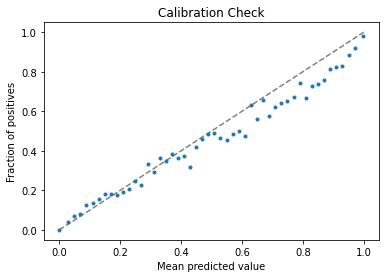

In [ ]:
print('Amount of data', len(probs_temp))
probs_array, y_test_array = pre_calibration(probs_temp, y_test_hot_encoded)
print(y_test_array[0])
print(len(probs_temp[0]))
ModelCalibration(probs_array, y_test_array)


#*Expected calibration error*

1.- Divide the predicted probabilities into bins:

   Choose the number of bins (e.g., 10).
  For each bin, assign a range of predicted probabilities. For example, if you choose 10 bins, you could assign the following ranges: [0, 0.1), [0.1, 0.2), ..., [0.9, 1.0).

2.- For each bin, calculate the average predicted probability and the average true probability of the corresponding events:

Calculate the average predicted probability for each bin by averaging the predicted probabilities of all the examples in that bin.
Calculate the average true probability for each bin by averaging the true probabilities (i.e., the hot encoded labels) of all the examples in that bin.

3.-Calculate the ECE as the weighted average of the absolute differences between the average predicted probabilities and the average true probabilities:

For each bin, calculate the absolute difference between the average predicted probability and the average true probability.
Multiply each absolute difference by the fraction of examples in that bin (i.e., the proportion of examples that fall into that bin).
Sum the weighted absolute differences over all the bins to get the ECE.

In [ ]:
import numpy as np

def expected_calibration_error(probs, labels, num_bins):
    # Step 1: Divide the predicted probabilities into bins.
    bin_boundaries = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(probs, bin_boundaries[1:-1])

    # Step 2: Calculate the average predicted and true probabilities for each bin.
    bin_probs = np.zeros(num_bins)
    bin_accs = np.zeros(num_bins)
    for i in range(num_bins):
        mask = bin_indices == i
        bin_probs[i] = np.mean(probs[mask])
        bin_accs[i] = np.mean(labels[mask])

    # Step 3: Calculate the ECE as the weighted average of the absolute differences.
    bin_sizes = np.histogram(probs, bins=bin_boundaries)[0]
    bin_fractions = bin_sizes / len(probs)
    ece = np.sum(bin_fractions * np.abs(bin_probs - bin_accs))

    return ece



#expected_calibration_error(probs_temp, y_test,100)

print('The expected calibration error of the network is:',expected_calibration_error(probs_temp, y_test_hot_encoded,10))

The expected calibration error of the network is: 0.09157772184923525


In [ ]:
def max_calibration_error(predicted_probs, true_labels, num_bins):
    # Divide the predicted probabilities into bins.
    bin_boundaries = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(predicted_probs, bin_boundaries[1:-1])

    # Initialize arrays to hold the average predicted probabilities and true probabilities.
    bin_probs = np.zeros(num_bins)
    bin_accs = np.zeros(num_bins)

    # Compute the average predicted and true probabilities for each bin.
    for i in range(num_bins):
        mask = bin_indices == i
        bin_probs[i] = np.mean(predicted_probs[mask])
        bin_accs[i] = np.mean(true_labels[mask])

    # Compute the absolute difference between the average predicted and true probabilities for each bin.
    bin_abs_diffs = np.abs(bin_probs - bin_accs)

    # Compute the maximum absolute difference.
    mce = np.max(bin_abs_diffs)

    return mce



print('The maximum calibration error is:',max_calibration_error(probs_temp, y_test_hot_encoded, 10) )

The maximum calibration error is: 0.1073676347732544


In [ ]:
# Plot the first image in x_train
plt.imshow(x_train[2])
print(y_train[2])

# Display the plot
plt.show()

#*Platt scaling*

In [ ]:
print('Amount of data', len(scaled_logits))
probs_lenet_array, y_test_array = pre_calibration(scaled_logits, y_test)
ModelCalibration(probs_lenet_array, y_test_array)

In [ ]:
# Get logits from the neural network
logits_model = keras.models.Model(inputs=new_model.input, outputs=new_model.layers[-2].output)
# Get logits using the logits_model from the previous example
logits = logits_model.predict(x_test)

In [ ]:
print(logits[0])
print(np.sum(logits[0]))
print(len(logits[0]))
scaled_probs=temperature_scaling(x_test, 1, logits)
# Print logits
print(scaled_probs[0])
print(np.sum(scaled_probs[0]))

In [ ]:
import numpy as np

# Define the temperature parameter
temperature = 2.0

# Apply temperature scaling to the logits
scaled_logits = logits / temperature

# Compute softmax probabilities
probs = np.exp(scaled_logits) / np.sum(np.exp(scaled_logits), axis=-1, keepdims=True)

# Print the original logits, scaled logits, and softmax probabilities
print('Original logits:', logits)
print('Scaled logits:', scaled_logits)
print('Softmax probabilities:', probs)


In [ ]:
last_layer_weights = new_model.layers[-1].get_weights()

# extract the weight matrix and bias vector
weight_matrix, bias_vector = last_layer_weights
print(len(weight_matrix[0]))
# apply the weights to the input vector
output = np.dot(weight_matrix, logits.T) + bias_vector

In [ ]:
print('Amount of data', len(probs))
probs_lenet_array, y_test_array = pre_calibration(probs, y_test)
ModelCalibration(probs_lenet_array, y_test_array)